# GRÁFICO DEL SILHOUETTE SCORE SEGÚN CADA ELIMINACIÓN

In [1]:
import math
from math import sqrt, log, floor
from sklearn.metrics import mean_squared_error
from statistics import mean
from fastdtw import fastdtw
from scipy import stats
from scipy.spatial.distance import pdist
 
#Euclidean
def euclidean(x, y):
    r=np.linalg.norm(x-y)
    if math.isnan(r):
        r=1
    #print(r)
    return r

#Fast Dynamic time warping
def fast_DTW(x, y):
    r, _ = fastdtw(x, y, dist=euclidean)
    if math.isnan(r):
        r=1
    #print(r)
    return r

#Spearman
def scorr(x, y):
    r = stats.spearmanr(x, y)[0]
    if math.isnan(r):
        r=0
    #print(r)
    return 1 - r

#RMSE
def rmse(x, y):
    r=sqrt(mean_squared_error(x,y))
    if math.isnan(r):
        r=1
    #print(r)
    return r

def lcs(a, b):  
    lengths = [[0 for j in range(len(b)+1)] for i in range(len(a)+1)]
    # row 0 and column 0 are initialized to 0 already
    for i, x in enumerate(a):
        for j, y in enumerate(b):
            if x == y:
                lengths[i+1][j+1] = lengths[i][j] + 1
            else:
                lengths[i+1][j+1] = max(lengths[i+1][j], lengths[i][j+1])
    x, y = len(a), len(b)
    result = lengths[x][y]
    return result

def discretise(x):
    return int(x * 10)

def multidim_lcs(a, b):
    a = a.applymap(discretise)
    b = b.applymap(discretise)
    rows, dims = a.shape
    lcss = [lcs(a[i+2], b[i+2]) for i in range(dims)]
    return 1 - sum(lcss) / (rows * dims)

#Correlation
def corr(x, y):
    r=np.dot(x-mean(x),y-mean(y))/((np.linalg.norm(x-mean(x)))*(np.linalg.norm(y-mean(y))))
    if math.isnan(r):
        r=0
    #print(r)
    return 1 - r

In [2]:
from sklearn.preprocessing import LabelEncoder
#from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
import scipy.cluster.hierarchy as hac
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import silhouette_score, calinski_harabasz_score

DIAMETER_METHODS = ['mean_cluster', 'farthest']
CLUSTER_DISTANCE_METHODS = ['nearest', 'farthest']

def inter_cluster_distances(labels, distances, method='nearest'):
    """Calculates the distances between the two nearest points of each cluster.
    :param labels: a list containing cluster labels for each of the n elements
    :param distances: an n x n numpy.array containing the pairwise distances between elements
    :param method: `nearest` for the distances between the two nearest points in each cluster, or `farthest`
    """
    if method not in CLUSTER_DISTANCE_METHODS:
        raise ValueError(
            'method must be one of {}'.format(CLUSTER_DISTANCE_METHODS))

    if method == 'nearest':
        return __cluster_distances_by_points(labels, distances)
    elif method == 'farthest':
        return __cluster_distances_by_points(labels, distances, farthest=True)


def __cluster_distances_by_points(labels, distances, farthest=False):
    n_unique_labels = len(np.unique(labels))
    cluster_distances = np.full((n_unique_labels, n_unique_labels),
                                float('inf') if not farthest else 0)

    np.fill_diagonal(cluster_distances, 0)

    for i in np.arange(0, len(labels) - 1):
        for ii in np.arange(i, len(labels)):
            if labels[i] != labels[ii] and (
                (not farthest and
                 distances[i, ii] < cluster_distances[labels[i], labels[ii]])
                    or
                (farthest and
                 distances[i, ii] > cluster_distances[labels[i], labels[ii]])):
                cluster_distances[labels[i], labels[ii]] = cluster_distances[
                    labels[ii], labels[i]] = distances[i, ii]
    return cluster_distances


def diameter(labels, distances, method='farthest'):
    """Calculates cluster diameters
    :param labels: a list containing cluster labels for each of the n elements
    :param distances: an n x n numpy.array containing the pairwise distances between elements
    :param method: either `mean_cluster` for the mean distance between all elements in each cluster, or `farthest` for the distance between the two points furthest from each other
    """
    if method not in DIAMETER_METHODS:
        raise ValueError('method must be one of {}'.format(DIAMETER_METHODS))

    n_clusters = len(np.unique(labels))
    diameters = np.zeros(n_clusters)

    if method == 'mean_cluster':
        for i in range(0, len(labels) - 1):
            for ii in range(i + 1, len(labels)):
                if labels[i] == labels[ii]:
                    diameters[labels[i]] += distances[i, ii]

        for i in range(len(diameters)):
            diameters[i] /= sum(labels == i)

    elif method == 'farthest':
        for i in range(0, len(labels) - 1):
            for ii in range(i + 1, len(labels)):
                if labels[i] == labels[ii] and distances[i, ii] > diameters[
                        labels[i]]:
                    diameters[labels[i]] = distances[i, ii]
    return diameters

def dunn(labels, distances, diameter_method='farthest',
         cdist_method='nearest'):
    """
    Dunn index for cluster validation (larger is better).
    
    .. math:: D = \\min_{i = 1 \\ldots n_c; j = i + 1\ldots n_c} \\left\\lbrace \\frac{d \\left( c_i,c_j \\right)}{\\max_{k = 1 \\ldots n_c} \\left(diam \\left(c_k \\right) \\right)} \\right\\rbrace
    
    where :math:`d(c_i,c_j)` represents the distance between
    clusters :math:`c_i` and :math:`c_j`, and :math:`diam(c_k)` is the diameter of cluster :math:`c_k`.
    Inter-cluster distance can be defined in many ways, such as the distance between cluster centroids or between their closest elements. Cluster diameter can be defined as the mean distance between all elements in the cluster, between all elements to the cluster centroid, or as the distance between the two furthest elements.
    The higher the value of the resulting Dunn index, the better the clustering
    result is considered, since higher values indicate that clusters are
    compact (small :math:`diam(c_k)`) and far apart (large :math:`d \\left( c_i,c_j \\right)`).
    :param labels: a list containing cluster labels for each of the n elements
    :param distances: an n x n numpy.array containing the pairwise distances between elements
    :param diameter_method: see :py:function:`diameter` `method` parameter
    :param cdist_method: see :py:function:`diameter` `method` parameter
    
    .. [Kovacs2005] Kovács, F., Legány, C., & Babos, A. (2005). Cluster validity measurement techniques. 6th International Symposium of Hungarian Researchers on Computational Intelligence.
    """

    labels = LabelEncoder().fit(labels).transform(labels)
    
    

    ic_distances = inter_cluster_distances(labels, distances, cdist_method)
    #print("IC",ic_distances)
    if len(ic_distances[ic_distances.nonzero()])==0:
        min_distance = 0
    else:
        min_distance = min(ic_distances[ic_distances.nonzero()])
    max_diameter = max(diameter(labels, distances, diameter_method))
    
    

    return min_distance / max_diameter

# Distancias

In [3]:
import pandas as pd
import os
my_path = os.path.abspath('')
my_path = my_path.split('\\')
my_path_py = "\\".join(my_path[:-1])

features = pd.read_csv(my_path_py+'\\2_FeatureBased\\FB2_2009al2013.csv', sep=',')

In [4]:
#features = features.iloc[:, 1:]
listadistrito = features.Distrito.values
features = features.drop('Distrito', axis=1)

In [5]:
features.shape[0]

200

In [6]:
lista_excluded = features.columns.tolist()
#lista_excluded.insert(0, 'None')
lista_excluded
lista3 = [17, 16, 13, 11, 10, 8, 6, 4]

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
n = features.shape[0]

#Euclidean
f_euclidean_dist = pd.read_csv(my_path_py+'\\2_FeatureBased\\MatrizEuclidiana_FB_K6.csv', sep=',').to_numpy()
#Corr
corr_dist = pd.read_csv(my_path_py+'\\2_FeatureBased\\MatrizPearson_FB_K6.csv', sep=',').to_numpy()

#scorr
f_scorr_dist = pd.read_csv(my_path_py+'\\2_FeatureBased\\MatrizSpearman_FB_K6.csv', sep=',').to_numpy()
#DTW
f_dtw_dist = pd.read_csv(my_path_py+'\\2_FeatureBased\\MatrizDTW_FB_K6.csv', sep=',').to_numpy()

In [8]:
KM_EUCLIDEAN=[]
KM_CORRELATION=[]
KM_SPEARMAN=[]
KM_DTW=[]
k=5
#Experimentos K-Means
km_euc = KMeans(n_clusters=k).fit_predict(f_euclidean_dist)
print("KM + euclidian distance: ")
sil = silhouette_score(f_euclidean_dist, km_euc)
print("SC: ", sil)
KM_EUCLIDEAN.append(sil)

km_corr = KMeans(n_clusters=k).fit_predict(corr_dist)
print("KM + corr distance: ")
sil = silhouette_score(corr_dist, km_corr)
print("SC: ", sil)
KM_CORRELATION.append(sil)

km_scorr = KMeans(n_clusters=k).fit_predict(f_scorr_dist)
print("KM + scorr distance: ")
sil = silhouette_score(f_scorr_dist, km_scorr)
print("SC: ", sil)
KM_SPEARMAN.append(sil)

km_dtw = KMeans(n_clusters=k).fit_predict(f_dtw_dist)
print("KM + dtw distance: ")
sil = silhouette_score(f_dtw_dist, km_dtw)
print("SC: ", sil)
KM_DTW.append(sil)
print("-----------------------")

KM + euclidian distance: 
SC:  0.8608449076842872
KM + corr distance: 
SC:  0.6676297567861202
KM + scorr distance: 
SC:  0.5938395092490075
KM + dtw distance: 
SC:  0.8588241791233674
-----------------------


In [9]:
features_aux = features.copy()
features.shape[1]

18

In [11]:
for i in lista3:
    features = features_aux.drop(features_aux.columns[i], axis=1)
    #Euclidean
    f_euclidean_dist = np.zeros((n,n))
    for i in range(0,n):
        #print("i",i)
        for j in range(1,n):
            #print("j",j)
            f_euclidean_dist[i,j] = euclidean(features.iloc[i].values.flatten(), features.iloc[j].values.flatten())
    #Corr
    f_corr_dist = np.zeros((n,n))
    for i in range(0,n):
        #print("i",i)
        for j in range(0,n):
           # print("j",j)
            f_corr_dist[i,j] = corr(features.iloc[i].values.flatten(), features.iloc[j].values.flatten())

    #scorr
    f_scorr_dist = np.zeros((n,n))
    for i in range(0,n):
        #print("i",i)
        for j in range(0,n):
           # print("j",j)
            f_scorr_dist[i,j] = scorr(features.iloc[i].values.flatten(), features.iloc[j].values.flatten())
    #DTW
    f_dtw_dist = np.zeros((n,n))
    for i in range(0,n):
        #print("i",i)
        for j in range(0,n):
            # print("j",j)
            f_dtw_dist[i,j] = fast_DTW(features.iloc[i].values.flatten(), features.iloc[j].values.flatten())
    print("--------------K-MEANS------------------")
    #Experimentos K-Means
    km_euc = KMeans(n_clusters=k).fit_predict(f_euclidean_dist)
    print("KM + euclidian distance: ")
    sil = silhouette_score(f_euclidean_dist, km_euc)
    print("SC: ", sil)
    KM_EUCLIDEAN.append(sil)

    km_corr = KMeans(n_clusters=k).fit_predict(f_corr_dist)
    print("KM + corr distance: ")
    sil = silhouette_score(f_corr_dist, km_corr)
    print("SC: ", sil)
    KM_CORRELATION.append(sil)

    km_scorr = KMeans(n_clusters=k).fit_predict(f_scorr_dist)
    print("KM + scorr distance: ")
    sil = silhouette_score(f_scorr_dist, km_scorr)
    print("SC: ", sil)
    KM_SPEARMAN.append(sil)

    km_dtw = KMeans(n_clusters=k).fit_predict(f_dtw_dist)
    print("KM + dtw distance: ")
    sil = silhouette_score(f_dtw_dist, km_dtw)
    print("SC: ", sil)
    KM_DTW.append(sil)

--------------K-MEANS------------------
KM + euclidian distance: 
SC:  0.8614294436424763
KM + corr distance: 
SC:  0.6657680577610273
KM + scorr distance: 
SC:  0.5347834153970298
KM + dtw distance: 
SC:  0.8594121930423203
--------------K-MEANS------------------
KM + euclidian distance: 
SC:  0.8614294436424763
KM + corr distance: 
SC:  0.6650659599421266
KM + scorr distance: 
SC:  0.5743448623534693
KM + dtw distance: 
SC:  0.8594121930423203
--------------K-MEANS------------------
KM + euclidian distance: 
SC:  0.8614294435622537
KM + corr distance: 
SC:  0.6657671651633956
KM + scorr distance: 
SC:  0.5933057217981568
KM + dtw distance: 
SC:  0.8594125047266215
--------------K-MEANS------------------
KM + euclidian distance: 
SC:  0.8614294436424741
KM + corr distance: 
SC:  0.6650659599415344
KM + scorr distance: 
SC:  0.5668333541249523
KM + dtw distance: 
SC:  0.8594127702654465
--------------K-MEANS------------------
KM + euclidian distance: 
SC:  0.8614294436389365
KM + corr 

In [26]:
KM_EUCLIDEAN.sort(reverse=False)

In [57]:
KM_EUCLIDEAN

[0.8569666614171854,
 0.8588570298884796,
 0.8608449076842872,
 0.8614294435622537,
 0.8614294436129012,
 0.8614294436389365,
 0.8614294436424741,
 0.8614294436424763,
 0.8614294436424763]

In [40]:
import math 

KM_EUCLIDEAN_log = []
for i in KM_EUCLIDEAN:
    KM_EUCLIDEAN_log.append(math.log(i*10))

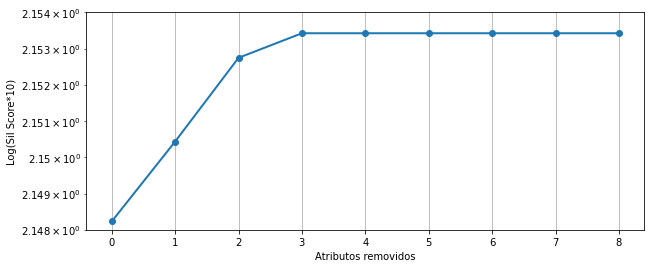

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=[10,4])
ax = plt.axes()
ax.plot(list(range(len(KM_EUCLIDEAN_log))), KM_EUCLIDEAN_log, linewidth=2, marker='o')
ax.set(ylim=(2.148, 2.154),
       xlabel='Atributos removidos', ylabel='Log(Sil Score*10)',
       #title='Sil vs N de atributos removidos');
      );
ax.grid(True)
ax.set_yscale('log')
plt.savefig(my_path_py + '\\Pictures\\SilScore_EliminacionF.png')


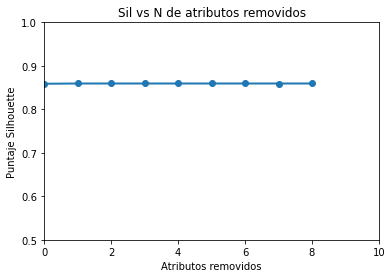

In [14]:
ax = plt.axes()
ax.plot(list(range(len(KM_DTW))), KM_DTW, linewidth=2, marker='o')
ax.set(xlim=(0, 10), ylim=(0.5, 1),
       xlabel='Atributos removidos', ylabel='Puntaje Silhouette',
       title='Sil vs N de atributos removidos');

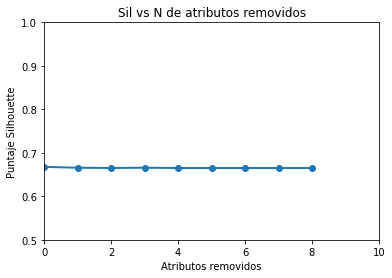

In [55]:
ax = plt.axes()
ax.plot(list(range(len(KM_CORRELATION))), KM_CORRELATION, linewidth=2, marker='o')
ax.set(xlim=(0, 10), ylim=(0.5, 1),
       xlabel='Atributos removidos', ylabel='Puntaje Silhouette',
       title='Sil vs N de atributos removidos');

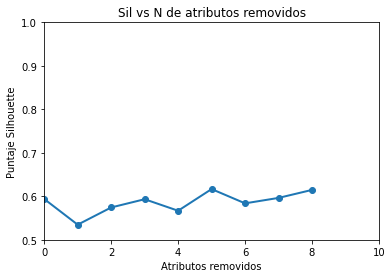

In [56]:
ax = plt.axes()
ax.plot(list(range(len(KM_SPEARMAN))), KM_SPEARMAN, linewidth=2, marker='o')
ax.set(xlim=(0, 10), ylim=(0.5, 1),
       xlabel='Atributos removidos', ylabel='Puntaje Silhouette',
       title='Sil vs N de atributos removidos');